## Trying to implement Grad-Cam  
Following   
https://medium.com/@codetrade/grad-cam-in-pytorch-a-powerful-tool-for-visualize-explanations-from-deep-networks-bdc7caf0b282  

https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569 

https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5  

In [226]:
import torch 
import numpy as np
import cv2
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


In [120]:
%run setup.ipynb

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079


In [227]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# keep track of activations and gradients
activations = None
gradients = None
# hooks for capturing activations and gradients 
def forward_hook(module, args, output):
    global activations
    print("forward")
    activations = output
    print(f'Activations size: {activations.size()}')

def backward_hook(module, grad_input, grad_output):
    global gradients
    print("backward")
    gradients = grad_output
    print(f'Gradients size: {gradients[0].size()}') 

def create_heatmap(model, imgpath,label, transforms=image_transforms):
    #open image
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transforms(img).unsqueeze(0)
    # first forward pass
    #set model to evaluation mode
    model.eval()
    #capture activations and gradients
    # we're interested in layer4 of resnet
    fw_hook = model.layer4.register_forward_hook(forward_hook, prepend=False)
    bw_hook = model.layer4.register_full_backward_hook(backward_hook, prepend=False)

    output = model(img_tensor)
    _, pred = torch.max(output, 1)
    print("Prediction: ",class_labels[pred.item()])

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label)
   
    # 4 backward pass
    loss.backward()

    # Compute the weights
    pooled_gradients = torch.mean(gradients[0], dim=[0,2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i].detach().cpu()

    # # Compute the Grad-CAM heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach())
    fw_hook.remove()
    bw_hook.remove()
    return heatmap.detach()


In [233]:

from IPython.display import display, Image
def visualize_heatmap_on_top(imgpath, heatmat, filepath):
    image = cv2.imread(imgpath)
    heatmap2 = cv2.resize(heatmat.numpy(), (image.shape[0],image.shape[1]))
    heatmap2 = np.uint8(255*heatmap2)
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    cv2_img = np.array(image)
    open_cv_image = cv2_img[:, :, ::-1].copy()
    superimposed_img = heatmap2 * 0.9 + open_cv_image
    cv2.imwrite(filepath, superimposed_img)
    display(Image(filepath))

In [217]:
greatPath = "just-bird-data/withBackground/greatTit/(39).jpg"
robinPath = "just-bird-data/withBackground/robin/(112).jpg"
starlingFeeder_hard = "feeder-data\starling\starling_752_31.png"
starlingFeeder = "feeder-data/starling/starling_752_17.png"
bluetitFeeder = "feeder-data/blueTit/blueTit_401_1.png"
bluetitPath = "just-bird-data/withBackground/blueTit/(146).jpg"
greatFeeder = "feeder-data/greatTit/greatTit_501_4.png"

bluetitTensor = torch.tensor([0])
greatTensor = torch.tensor([4])
robinTensor = torch.tensor([5])
starlingTensor = torch.tensor([6])

### Prepare models to compare

In [221]:
model_base = load_and_prep_resnet50()
loaded = torch.load("base_lr0.0005.tar",map_location=torch.device('cpu'))
model_base.load_state_dict(loaded["model"])
unfreeze_layers(model_base)
# model_base.eval()
print_stats(loaded["info"])

Lowest loss was 0.0922 at epoch 49
Highest accuracy was 1.0000 at epoch 26
Number of epochs run  50
Batch size was  16
Optimizer used:  Adam with lr=0.0005
Overall accuracy on test data 97.1429


In [222]:
model_fine, i_fine = load_function("fine_base.tar")
# model_fine.eval()
unfreeze_layers(model_fine)
print_stats(i_fine)

Lowest loss was 0.0031 at epoch 9
Highest accuracy was 1.0000 at epoch 2
Number of epochs run  10
Batch size was  16
Optimizer used:  Adam with lr=0.0005
Overall accuracy on test data 99.0476
Overall accuracy on feeder data 58.4256


### Visualize birds

#### BlueTit

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


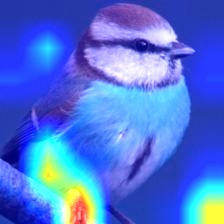

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


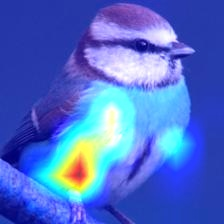

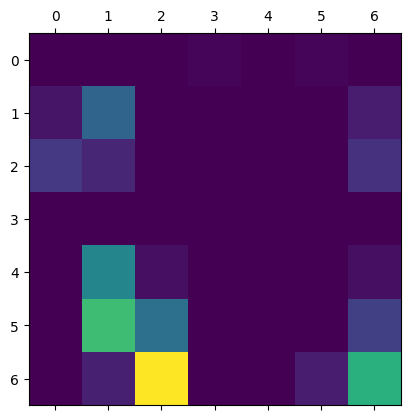

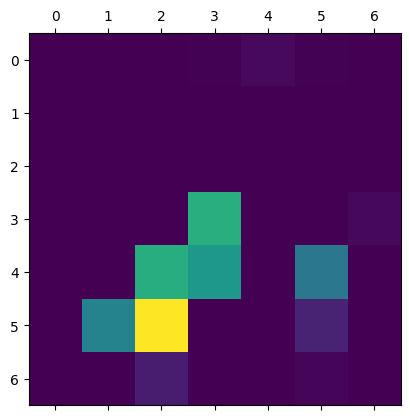

In [218]:
bluemat_base = create_heatmap(model=model_base, imgpath=bluetitPath, label=bluetitTensor)
visualize_heatmap_on_top(bluetitPath, heatmat=bluemat_base, filepath="./bluetit.jpg")
bluemat_fine = create_heatmap(model=model_fine, imgpath=bluetitPath, label=bluetitTensor)
visualize_heatmap_on_top(bluetitPath, heatmat=bluemat_fine, filepath="./bluetit.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


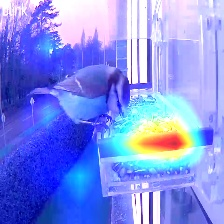

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


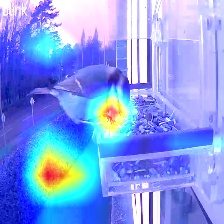

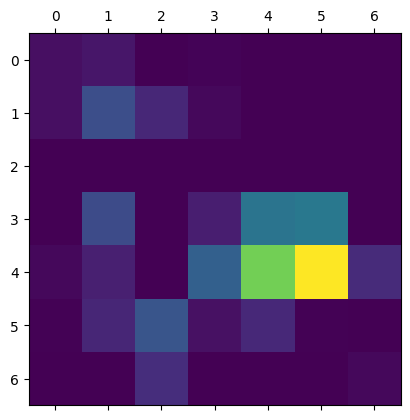

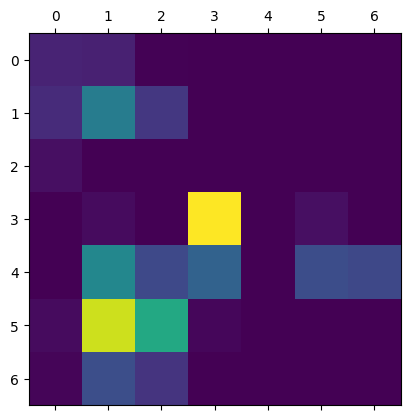

In [180]:
bluemat_base2 = create_heatmap(model=model_base, imgpath=bluetitFeeder, label=bluetitTensor)
visualize_heatmap_on_top(bluetitFeeder, heatmat=bluemat_base2, filepath="./bluetit.jpg")
bluemat_fine2 = create_heatmap(model=model_fine, imgpath=bluetitFeeder, label=bluetitTensor)
visualize_heatmap_on_top(bluetitFeeder, heatmat=bluemat_fine2, filepath="./bluetit.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


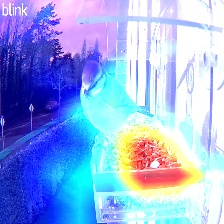

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


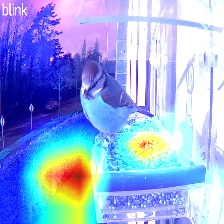

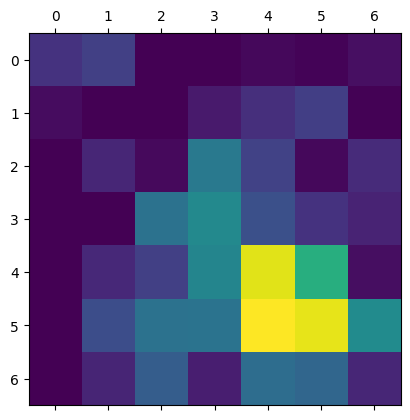

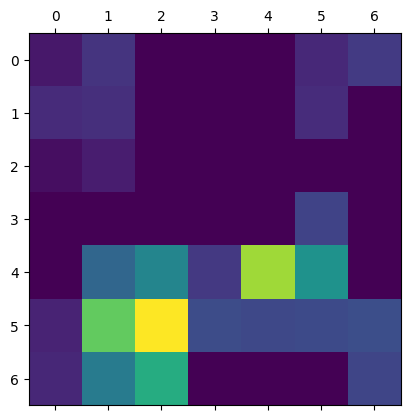

In [252]:
another = "feeder-data/blueTit/blueTit_455_30.png"
bluemat_base3 = create_heatmap(model=model_base, imgpath=another, label=bluetitTensor)
visualize_heatmap_on_top(another, heatmat=bluemat_base3, filepath="./bluetit.jpg")
bluemat_fine3 = create_heatmap(model=model_fine, imgpath=another, label=bluetitTensor)
visualize_heatmap_on_top(another, heatmat=bluemat_fine3, filepath="./bluetit.jpg")

#### GreatTit

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


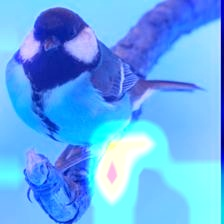

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


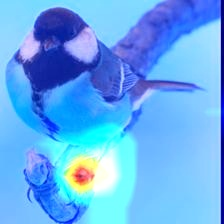

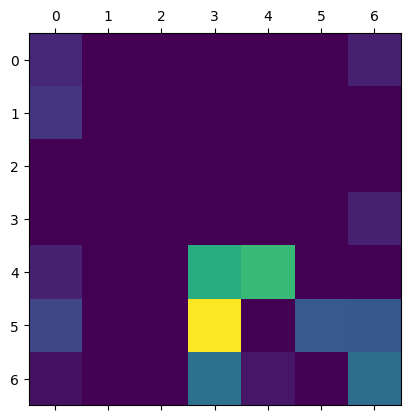

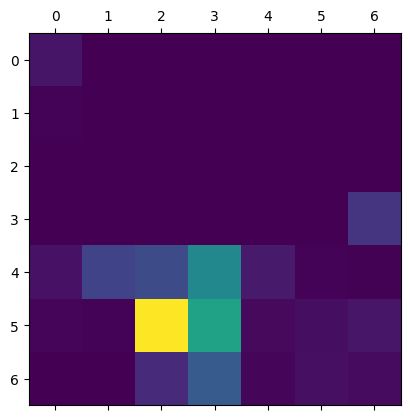

In [181]:
greatmap_base = create_heatmap(model=model_base, imgpath=greatPath, label=greatTensor)
visualize_heatmap_on_top(greatPath, heatmat=greatmap_base, filepath="./great.jpg")
greatmap_fine = create_heatmap(model=model_fine, imgpath=greatPath, label=greatTensor)
visualize_heatmap_on_top(greatPath, heatmat=greatmap_fine, filepath="./great.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


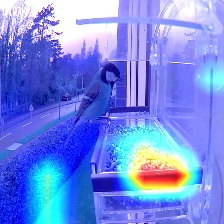

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


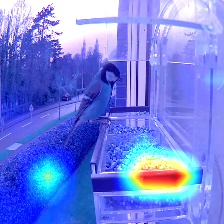

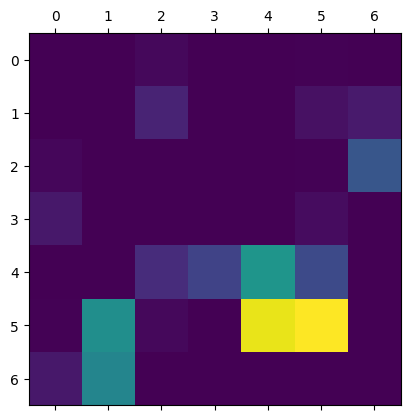

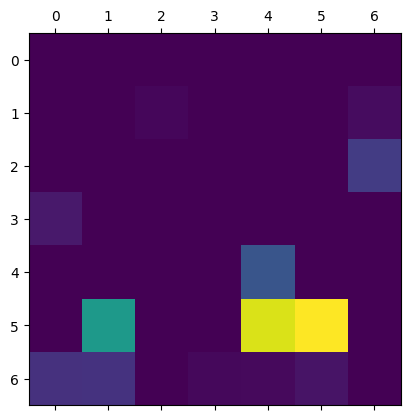

In [182]:
greatmap_base2 = create_heatmap(model=model_base, imgpath=greatFeeder, label=greatTensor)
visualize_heatmap_on_top(greatFeeder, heatmat=greatmap_base2, filepath="./great.jpg")
greatmap_fine2 = create_heatmap(model=model_fine, imgpath=greatFeeder, label=greatTensor)
visualize_heatmap_on_top(greatFeeder, heatmat=greatmap_fine2, filepath="./great.jpg")

#### Robin

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  robin
backward
Gradients size: torch.Size([1, 2048, 7, 7])


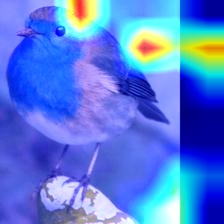

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  robin
backward
Gradients size: torch.Size([1, 2048, 7, 7])


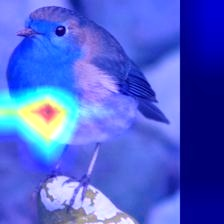

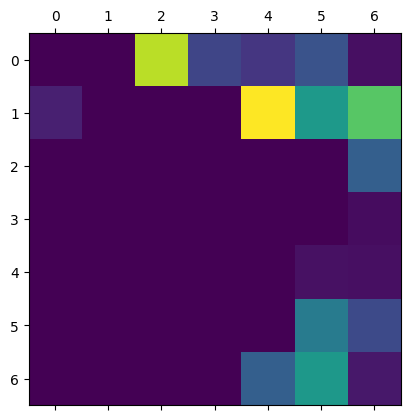

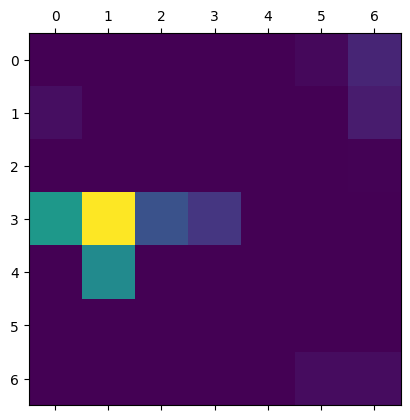

In [183]:
greatmap_base = create_heatmap(model=model_base, imgpath=robinPath, label=robinTensor)
visualize_heatmap_on_top(robinPath, heatmat=greatmap_base, filepath="./great.jpg")
greatmap_fine = create_heatmap(model=model_fine, imgpath=robinPath, label=robinTensor)
visualize_heatmap_on_top(robinPath, heatmat=greatmap_fine, filepath="./great.jpg")

#### Starling

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


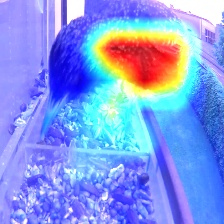

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


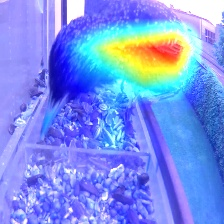

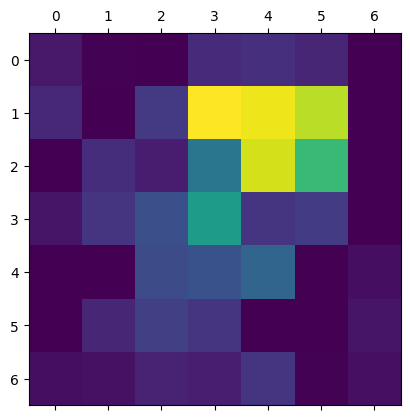

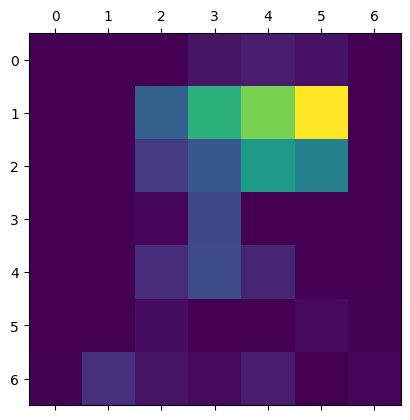

In [ ]:
starling_base = create_heatmap(model=model_base, imgpath=starlingFeeder, label=starlingTensor)
visualize_heatmap_on_top(starlingFeeder, heatmat=starling_base, filepath="./image.jpg")
starling_fine = create_heatmap(model=model_fine, imgpath=starlingFeeder, label=starlingTensor)
visualize_heatmap_on_top(starlingFeeder, heatmat=starling_fine, filepath="./image.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  goldfinch
backward
Gradients size: torch.Size([1, 2048, 7, 7])


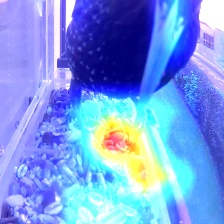

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


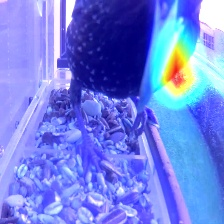

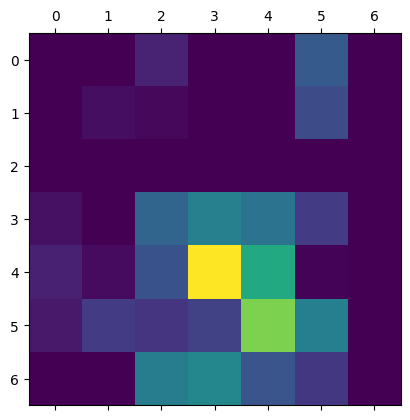

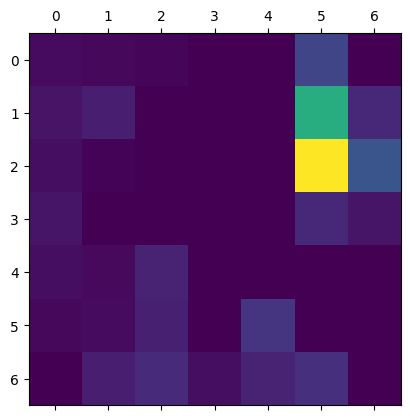

In [205]:
starlingFeeder_hard = "feeder-data\starling\starling_702_37.png"
starling_base2 = create_heatmap(model=model_base, imgpath=starlingFeeder_hard, label=starlingTensor)
visualize_heatmap_on_top(starlingFeeder_hard, heatmat=starling_base2, filepath="./image.jpg")
starling_fine2 = create_heatmap(model=model_fine, imgpath=starlingFeeder_hard, label=starlingTensor)
visualize_heatmap_on_top(starlingFeeder_hard, heatmat=starling_fine2, filepath="./image.jpg")

#### Chaffinch

In [250]:
chafPath = "split_withbackground/train/chaffinch/(134).jpg"
chafPath2 = "feeder-data/chaffinch/chaffinchM_208_20.png"
chaffem = "feeder-data\chaffinch\chaffinchF_125_34.png"
chafTensor = torch.tensor([1])

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  chaffinch
backward
Gradients size: torch.Size([1, 2048, 7, 7])


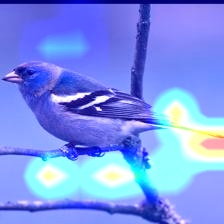

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  chaffinch
backward
Gradients size: torch.Size([1, 2048, 7, 7])


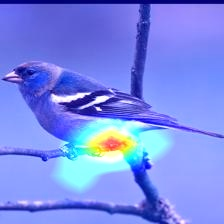

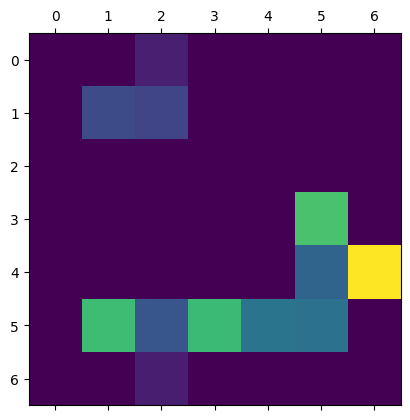

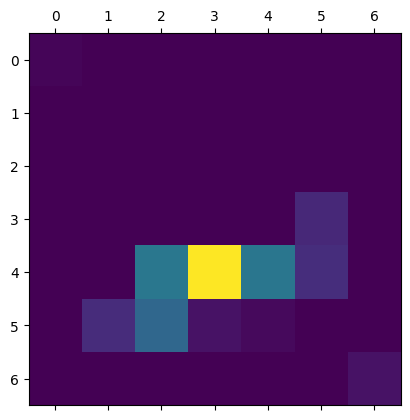

In [251]:
chafmat_base = create_heatmap(model=model_base, imgpath=chafPath, label=chafTensor)
visualize_heatmap_on_top(chafPath, heatmat=chafmat_base, filepath="./chaf.jpg")
chafmat_fine = create_heatmap(model=model_fine, imgpath=chafPath, label=chafTensor)
visualize_heatmap_on_top(chafPath, heatmat=chafmat_fine, filepath="./chaf.jpg")

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


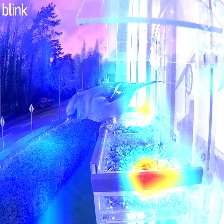

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  starling
backward
Gradients size: torch.Size([1, 2048, 7, 7])


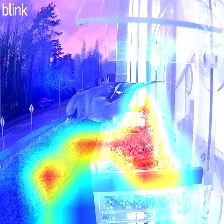

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  greatTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


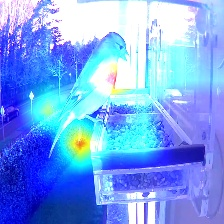

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  blueTit
backward
Gradients size: torch.Size([1, 2048, 7, 7])


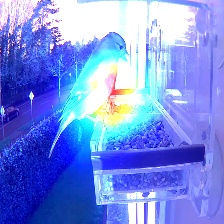

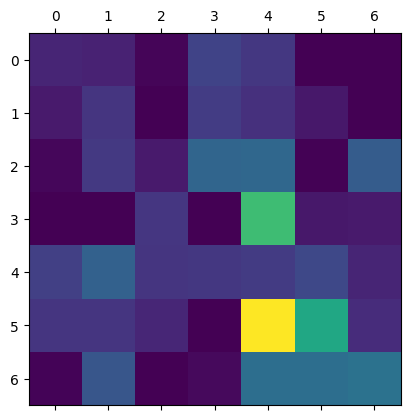

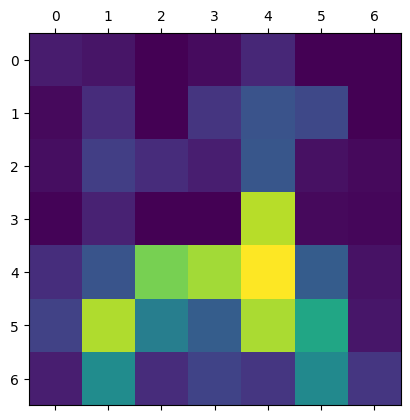

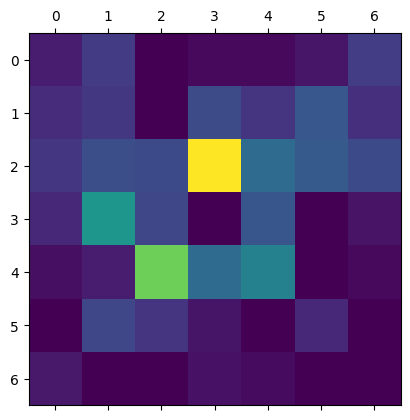

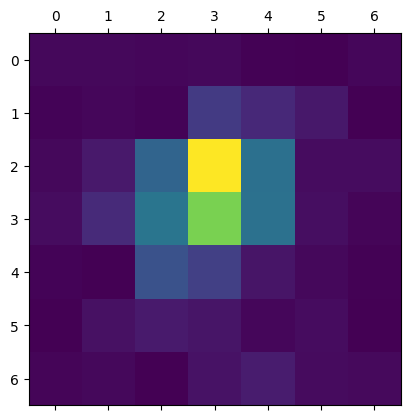

In [235]:

chafmat_base = create_heatmap(model=model_base, imgpath=chafPath2, label=chafTensor)
visualize_heatmap_on_top(chafPath2, heatmat=chafmat_base, filepath="./chaf.jpg")
chafmat_fine = create_heatmap(model=model_fine, imgpath=chafPath2, label=chafTensor)
visualize_heatmap_on_top(chafPath2, heatmat=chafmat_fine, filepath="./chaf.jpg")

chafmat_base = create_heatmap(model=model_base, imgpath=chaffem, label=chafTensor)
visualize_heatmap_on_top(chaffem, heatmat=chafmat_base, filepath="./chaf.jpg")
chafmat_fine = create_heatmap(model=model_fine, imgpath=chaffem, label=chafTensor)
visualize_heatmap_on_top(chaffem, heatmat=chafmat_fine, filepath="./chaf.jpg")

#### Goldfinch

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  goldfinch
backward
Gradients size: torch.Size([1, 2048, 7, 7])


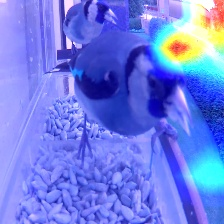

forward
Activations size: torch.Size([1, 2048, 7, 7])
Prediction:  goldfinch
backward
Gradients size: torch.Size([1, 2048, 7, 7])


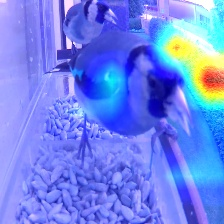

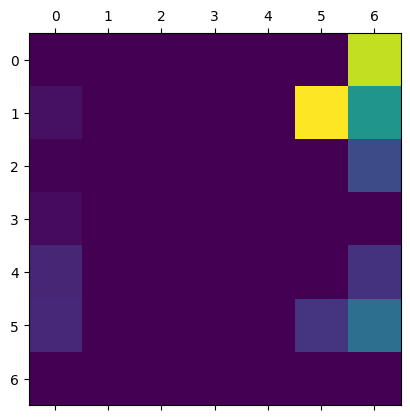

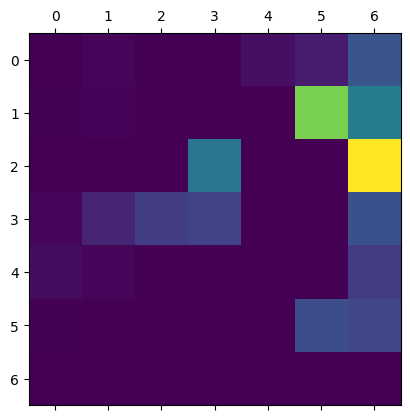

In [ ]:
gold = "feeder-data/goldfinch/goldfinch_824_17.png"
goldTensor = torch.tensor([3])
chafmat_base2 = create_heatmap(model=model_base, imgpath=gold, label=goldTensor)
visualize_heatmap_on_top(gold, heatmat=chafmat_base2, filepath="./chaf.jpg")
chafmat_fine2 = create_heatmap(model=model_fine, imgpath=gold, label=goldTensor)
visualize_heatmap_on_top(gold, heatmat=chafmat_fine2, filepath="./chaf.jpg")